<a href="https://colab.research.google.com/github/Bayaniblues/DS-Unit-2-Kaggle-Challenge/blob/master/DS-Unit-2-Kaggle-Challenge/Copy_of_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [ ]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)


def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

import category_encoders as ce
encoder = ce.OrdinalEncoder()

# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [ ]:
X_train

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,year_recorded,month_recorded,day_recorded,years,basin,region,public_meeting,scheme_management,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,longitude_MISSING,latitude_MISSING,construction_year_MISSING,gps_height_MISSING,population_MISSING,years_MISSING
43360,0.0,NaN,33.542898,-9.174777,0,12,4,NaN,NaN,2011,7,27,NaN,Lake Nyasa,Mbeya,True,VWC,NaN,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,False,False,True,True,True,True
7263,500.0,2049.0,34.665760,-9.308548,0,11,4,175.0,2008.0,2011,3,23,3.0,Rufiji,Iringa,True,WUA,True,gravity,gravity,gravity,wua,user-group,pay monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,False,False,False,False,False,False
2486,25.0,290.0,38.238568,-6.179919,0,6,1,2300.0,2010.0,2011,3,7,1.0,Wami / Ruvu,Pwani,True,VWC,False,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,salty,salty,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,False,False,False,False,False,False
313,0.0,NaN,30.716727,-1.289055,0,18,1,NaN,NaN,2011,7,31,NaN,Lake Victoria,Kagera,True,NaN,True,other,other,other,vwc,user-group,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,False,False,True,True,True,True
52726,0.0,NaN,35.389331,-6.399942,0,1,6,NaN,NaN,2011,3,10,NaN,Internal,Dodoma,True,VWC,True,mono,mono,motorpump,vwc,user-group,pay per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,False,False,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,50.0,489.0,38.268574,-5.450254,4,4,6,1300.0,2009.0,2011,3,28,2.0,Pangani,Tanga,True,VWC,False,submersible,submersible,submersible,vwc,user-group,pay per bucket,soft,good,enough,river,river/lake,surface,communal standpipe,communal standpipe,False,False,False,False,False,False
58170,0.0,NaN,33.926294,-9.641293,0,12,3,NaN,NaN,2011,12,7,NaN,Lake Nyasa,Mbeya,True,VWC,True,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,dry,spring,spring,groundwater,communal standpipe,communal standpipe,False,False,True,True,True,True
17191,0.0,599.0,39.262924,-10.768079,0,90,33,1.0,2012.0,2013,2,2,1.0,Ruvuma / Southern Coast,Mtwara,True,VWC,False,submersible,submersible,submersible,vwc,user-group,other,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,False,False,False,False,False,False
8192,30.0,426.0,39.348550,-10.642069,0,90,33,320.0,1988.0,2013,2,7,25.0,Ruvuma / Southern Coast,Mtwara,True,VWC,False,submersible,submersible,submersible,vwc,user-group,pay per bucket,soft,good,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,False,False,False,False,False,False


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from category_encoders import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import RandomizedSearchCV

%time
model = Pipeline([
                  ('ohe', OrdinalEncoder()),
                  ('impute', SimpleImputer()),
                  ('classifier', RandomForestClassifier())
])

model.fit(X_train,y_train)
print(model.score(X_train, y_train))
print(model.score(X_val, y_val))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
0.9978745791245791
0.8097643097643098


In [ ]:
https://colab.research.google.com/drivehttps://colab.research.google.com/drive/1MpDvBhCjPBQSDIr7h1rw6nvDzb2wUIme#scrollTo=KbqrrxPV8-Fg/1MpDvBhCjPBQSDIr7h1rw6nvDzb2wUIme#scrollTo=KbqrrxPV8-Fg
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestClassifier()
)


#pipeline.fit(X_train,y_train)
##print(pipeline.score(X_train, y_train))
#print(pipeline.score(X_val, y_val))

SyntaxError: ignored

In [ ]:
SimpleImputer()

In [ ]:
RandomForestClassifier()

In [ ]:

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'],
}

In [ ]:
from sklearn.model_selection import GridSearchCV
Grid = GridSearchCV(pipeline, param_distributions)
Grid.fit(X_train, y_train);

In [ ]:
print(Grid.score(X_train, y_train))
print(Grid.score(X_val, y_val))


In [ ]:
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=5, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

In [ ]:
search.best_params_

In [ ]:
print(search.score(X_train, y_train))
print(search.score(X_val, y_val))


In [ ]:
y_pred = search.predict(X_test)


In [ ]:
# estimator is your model or pipeline, which you've fit on X_train

# X_test is your pandas dataframe or numpy array, 
# with the same number of rows, in the same order, as test_features.csv, 
# and the same number of columns, in the same order, as X_train

y_pred = Grid.predict(X_test)


# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index

DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('cortezgrid.csv', index=False)


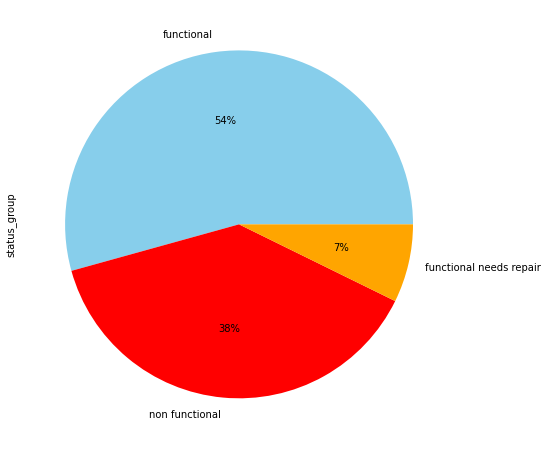

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
train.status_group.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'red', 'orange'])


In [ ]:
y_pred = model.predict(X_val)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

In [ ]:
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

In [ ]:


def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    return columns, index

plot_confusion_matrix(y_val, y_pred)



(['Predicted functional',
  'Predicted functional needs repair',
  'Predicted non functional'],
 ['Actual functional',
  'Actual functional needs repair',
  'Actual non functional'])

In [ ]:


def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return table

plot_confusion_matrix(y_val, y_pred)



,Predicted functional,Predicted functional needs repair,Predicted non functional
Actual functional,5687,194,571
Actual functional needs repair,426,295,142
Actual non functional,859,77,3629


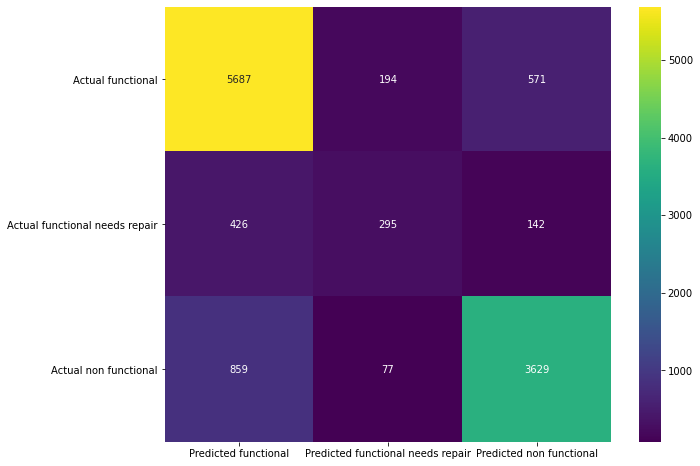

In [ ]:
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_val, y_pred);